Выполнила: Анастасия Плавина

## Урок 5. Задача оттока: варианты постановки, возможные способы решения

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

###  Цель: 
Выбрать оптимальную модель предсказания оттока банковских клиентов

### Данные
https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers

In [25]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, classification_report, precision_recall_curve, confusion_matrix
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [93]:
# функции визуализации

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    
    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()
    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # считаем деньги
    # Ценность модели = Прибыль c ML - Прибыль без ML 
    
    retention_rate = 10
    revenue_rate = 20

    revenue = cm[1][1]*revenue_rate + cm[0][0]*revenue_rate
    lost_revenue = cm[1][0]*revenue_rate

    retention_cost = cm[1][1]*retention_rate
    extra_retention_cost = cm[0][1]*retention_rate


    # получили прибыль со всех, кто остался в банке, вычли расходы на удержание всех
    rubl_all_retain = revenue - np.sum(cm) * retention_rate
    
    # прибыль от сохраненных клиентов - расходы на удержание - расходы на удержание неправильно предсказанных
    # - Упущенная прибыль от неправильно предсказанных
    rubl_ML = revenue-retention_cost-lost_revenue-extra_retention_cost
    
    print(f'Total revenue:{rubl_ML-rubl_all_retain}$')
    
    results['ML_revenue'].append(revenue)
    results['ML_retention cost'].append(retention_cost+extra_retention_cost)
    results['ML_lost revenue'].append(lost_revenue)
    
    results['ML_total revenue'].append(rubl_ML-rubl_all_retain)
    

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Загрузка данных

In [71]:
df = pd.read_csv("churn_data.csv")
df.head(3)

df = df.drop('CustomerId', 1)
df.head(5)

,RowNumber,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [72]:
df.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


In [73]:
df.describe()

,RowNumber,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [74]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

### Анализ целевой переменной

Соотношение целевой переменной:
0 (нет оттока) - 80%
1 (отток) - 20%


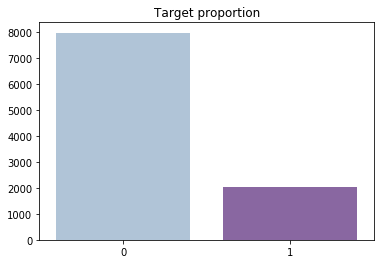

In [75]:
target = 'Exited'
features = df.columns.drop(target).tolist()

counts = df[target].value_counts()

print('Соотношение целевой переменной:')
print(f'0 (нет оттока) - {counts[0]/df.shape[0]*100:.0f}%')
print(f'1 (отток) - {counts[1]/df.shape[0]*100:.0f}%')
  
plt.title('Target proportion')
sns.barplot(counts.index, counts.values, palette='BuPu')
plt.show()

Вывод: классы не сбалансированы (1 к 4)

### Распределения признаков

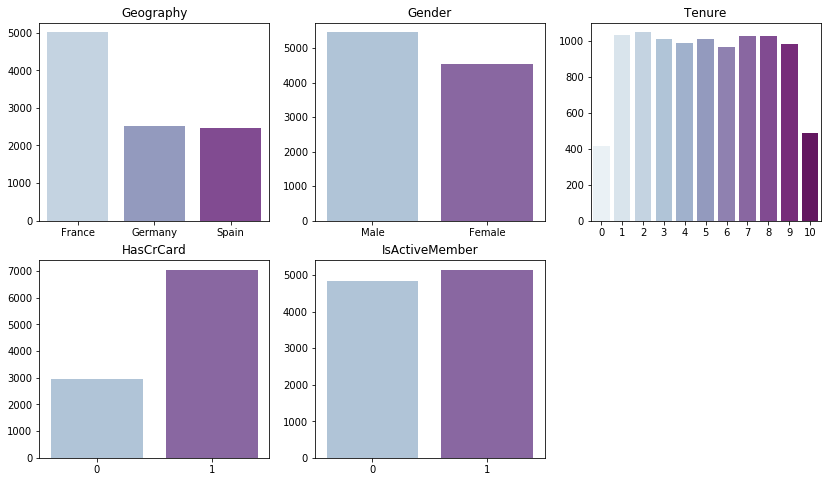

In [76]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(14, 8))

for i, ax in enumerate(axes.flat):
    if i != 5:
        counts = df[categorical_columns[i]].value_counts()
#         print(str(categorical_columns[i]))
#         for name in counts.index:  
#             print(f'{name} - {counts[name]/df.shape[0]*100:.0f}%')
        sns.barplot(counts.index, counts.values, ax=ax, palette='BuPu')
        ax.set_title(categorical_columns[i])
#         print('\n-------------------------')
    else:
        break
        
axes[1][2].set_visible(False)
plt.show()

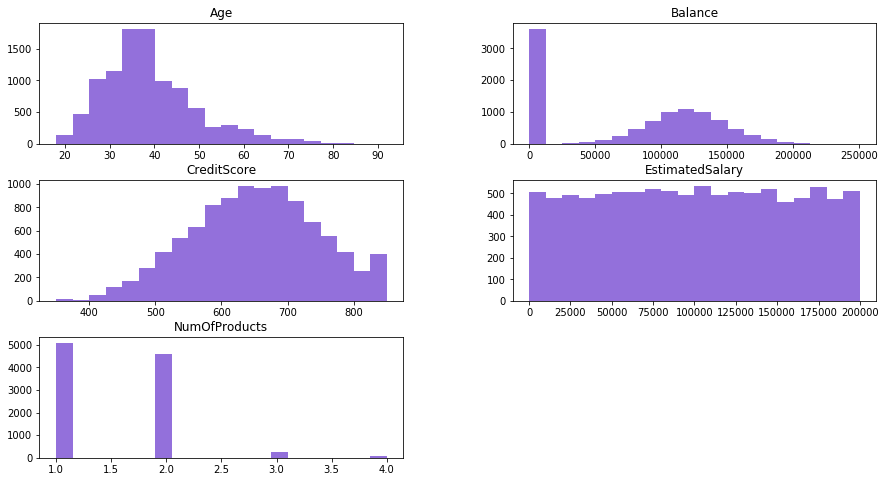

In [77]:
df[continuous_columns].hist(figsize=(15,8), bins=20, grid=False, color='mediumpurple')
plt.show()

### Подготовка данных к обучению

In [78]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные признаки стандартизируем

In [79]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [80]:
df.head(3)

,RowNumber,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [81]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)), 
                ('scaler', StandardScaler()) # добавляем стандартизацию
            ])
    final_transformers.append((cont_col, cont_transformer))

Итоговый пайплайн:

In [82]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

### Обучение

In [94]:
results = {
    'classifier': [], 
    'F-Score': [], 
    'Precision': [], 
    'Recall': [], 
    'ML_revenue': [], 
    'ML_retention cost': [],
    'ML_lost revenue': [],
    'ML_total revenue': []
           
}

In [95]:
model_names = ['RandomForest', 'LogisticRegression', 'GradientBoosting', 'lgbm']
models = [RandomForestClassifier(random_state = 42), LogisticRegression(random_state = 42), 
          GradientBoostingClassifier(random_state=42), lgbm.LGBMClassifier(random_state=42)]
 
def learning_pipline(classifier):
    pipeline = Pipeline([
        ('features',feats),
        ('classifier', classifier),
    ])

    pipeline.fit(X_train, y_train)
    return pipeline.predict_proba(X_test)[:, 1]


### Анализ метрик

--------------------------------------------------------------------------------------
1 RandomForest
Best Threshold=0.380000, F-Score=0.641, Precision=0.654, Recall=0.629
classification_report

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1991
           1       0.67      0.62      0.64       509

    accuracy                           0.86      2500
   macro avg       0.78      0.77      0.78      2500
weighted avg       0.86      0.86      0.86      2500



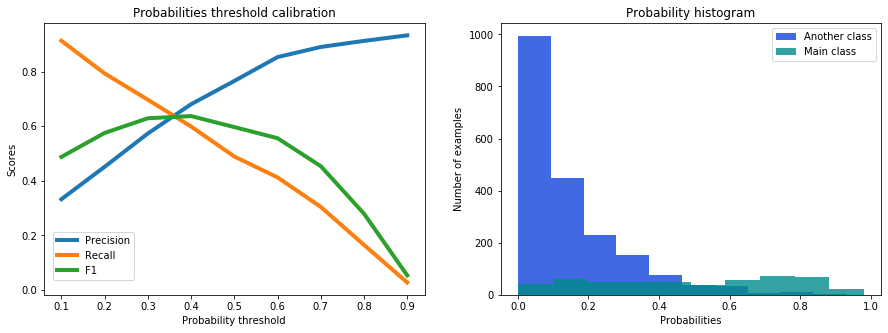

Confusion matrix, without normalization
Total revenue:16380$


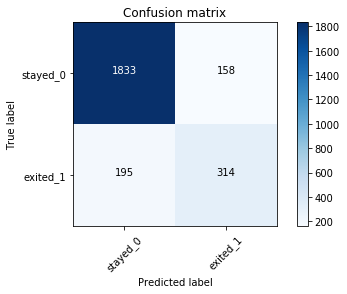

--------------------------------------------------------------------------------------
2 LogisticRegression
Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568
classification_report

              precision    recall  f1-score   support

           0       0.88      0.83      0.86      1991
           1       0.46      0.57      0.51       509

    accuracy                           0.78      2500
   macro avg       0.67      0.70      0.68      2500
weighted avg       0.80      0.78      0.79      2500



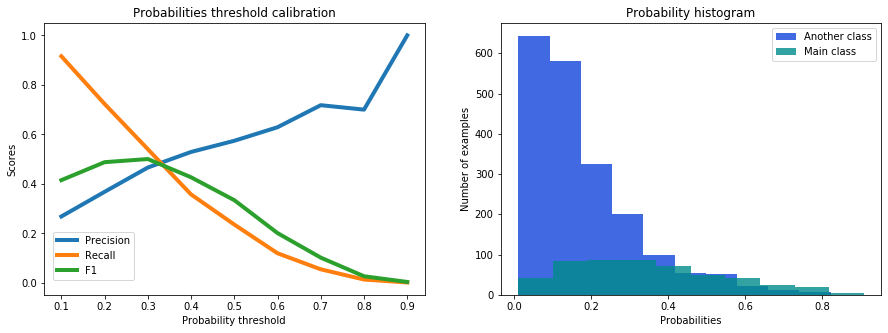

Confusion matrix, without normalization
Total revenue:14340$


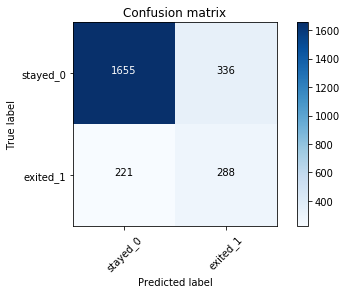

--------------------------------------------------------------------------------------
3 GradientBoosting
Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597
classification_report

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1991
           1       0.70      0.60      0.64       509

    accuracy                           0.87      2500
   macro avg       0.80      0.77      0.78      2500
weighted avg       0.86      0.87      0.86      2500



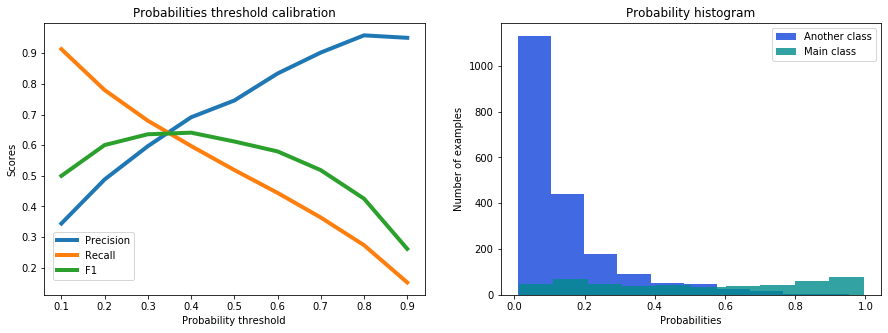

Confusion matrix, without normalization
Total revenue:16570$


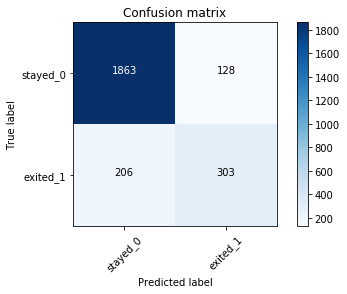

--------------------------------------------------------------------------------------
4 lgbm
Best Threshold=0.290514, F-Score=0.644, Precision=0.583, Recall=0.719
classification_report

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1991
           1       0.58      0.72      0.64       509

    accuracy                           0.84      2500
   macro avg       0.75      0.79      0.77      2500
weighted avg       0.85      0.84      0.84      2500



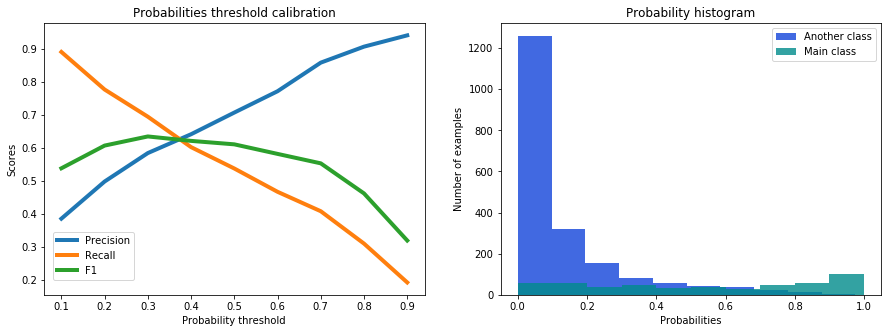

Confusion matrix, without normalization
Total revenue:15850$


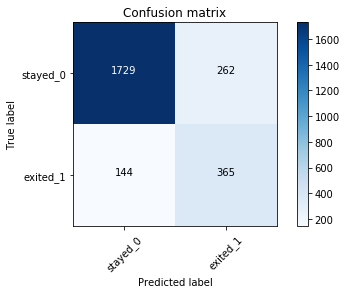

In [96]:
for i in range(len(models)):
    print('--------------------------------------------------------------------------------------')
    print(i+1, model_names[i])
    results['classifier'].append(model_names[i])
    preds = learning_pipline(models[i])
    precision, recall, thresholds = precision_recall_curve(y_test, preds)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

    results['F-Score'].append(fscore[ix])
    results['Precision'].append(precision[ix])
    results['Recall'].append(recall[ix])
    
    print('classification_report\n\n' + classification_report(y_test, preds>thresholds[ix]))
    show_proba_calibration_plots(preds, y_test)

    
    plot_confusion_matrix(confusion_matrix(y_test, preds>thresholds[ix]), classes=['stayed_0', 'exited_1'],
                          title='Confusion matrix')
    plt.show()




На градиентном бустинге получаем лучший F1-score (его оптимально смотреть при несбалансированности классов). На гистограмме видим, что GradientBoosting наилучшим образом разделяет классы. По матрице ошибок видим, что lgbm лучше всех предсказывает целевой класс (пропускает только 28% оттекших клиентов, бустинг пропускает - 40%, а лес - 38%), а бустинг  меньше всех ошибается (6%) на тех, кто остался, чем случайный лес (8%) и lgbm (13%).

<b>Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?</b>

Ценность модели измеряем по формуле:
    
Ценность модели $=$ Прибыль с применением ML $-$ Прибыль без применения ML

Прибыль без применения ML $=$ Прибыль от сохраненных клиентов $-$ Расходы на удержание всех клиентов

Прибыль с применением ML $=$ Прибыль от сохраненных клиентов (в т.ч. удержанных) $-$ Расходы на удержание правильно предсказанных $-$ Упущенная прибыль от неправильно предсказанных $-$ Расходы на удержание неправильно предсказанных
    
   

In [97]:
df_results = pd.DataFrame(results).sort_values('ML_total revenue', axis=0, ascending=False).reset_index(drop=True)
df_results

,classifier,F-Score,Precision,Recall,ML_revenue,ML_retention cost,ML_lost revenue,ML_total revenue
0,GradientBoosting,0.646121,0.703704,0.597250,43320,4310,4120,16570
1,RandomForest,0.641283,0.654397,0.628684,42940,4720,3900,16380
2,lgbm,0.643799,0.582803,0.719057,41880,6270,2880,15850
3,LogisticRegression,0.509700,0.462400,0.567780,38860,6240,4420,14340


Анализ стоимости на прибыль от текущих клиентов и удержанных доказала наибольшую эффективность GradientBoosting. Прибыль при использовании этой модели на 1% больше, чем у случайного леса и на 5% чем у lgbm. Делаем вывод: лучше меньше ошибаться на тех, кто остается, чем луше предсказывать отток, чтобы меньше тратить на ненужное удержание (к тому же есть риск, что удержание может вылиться в отток через неправильное воздейтсвие на клиента)

#### Вопрос 1: объясните своими словами смысл метрик Precison, Recall *
1. Какова их взаимосвязь и как с ними связан порог вероятности? 
2. Можно ли подобрать порог так, что recall будет равен 1? Что при этом будет с precision
3. Аналогичный вопрос про precision


**Ответ**: Порог вероятности необходимо выбрать таким образом, чтобы метрики были оптимально высоки относительно друг друга. Если мы повышаем recall (метрику покрытия всех объектов целевого класа, т.е. как точно мы предсказваем тех, кто оттекает), мы всегда теряем в precision(метрика того, насколько точно мы предсказываем объекты целевого класса и не ошибаемся на тех, кто не оттекает) и наоборот. В связи с этим всегда важно смотреть на f1, которая представляет собой гармоническое среднее этих метрик. 

### Калибровка лучшей модели

In [58]:
params={'classifier__n_estimators':[20, 50, 100, 200],
        'classifier__min_samples_leaf':[5, 10, 50, 100],
        'classifier__max_depth':[2, 3, 5, 7, 10, 15]
        }

Запускаем перебор

In [100]:
# %%time
# grid = GridSearchCV(Pipeline([
#                         ('features',feats),
#                         ('classifier', GradientBoostingClassifier(random_state=42))]),
#                     param_grid=params,
#                     cv=5,
#                     refit=False)

# search = grid.fit(X_train, y_train)
# search.best_params_

{'classifier__max_depth': 5,
 'classifier__min_samples_leaf': 5,
 'classifier__n_estimators': 50}

Обучаем модель уже с новыми параметрами 

In [101]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(max_depth=5, min_samples_leaf=5,n_estimators=50, random_state=42)),
])
pipeline.fit(X_train, y_train)
calibrated_preds = pipeline.predict_proba(X_test)[:, 1]

Best Threshold=0.324085, F-Score=0.635, Precision=0.617, Recall=0.654
Confusion matrix, without normalization
Total revenue:16070$


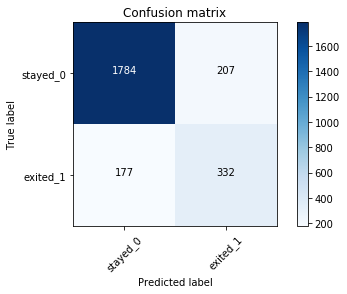

In [102]:
precision, recall, thresholds = precision_recall_curve(y_test, calibrated_preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                    fscore[ix],
                                                                    precision[ix],
                                                                    recall[ix]))

plot_confusion_matrix(confusion_matrix(y_test, calibrated_preds>thresholds[ix]), classes=['stayed_0', 'exited_1'],
                      title='Confusion matrix')
plt.show()

Вывод: калибровка не дала улучшение модели с точки зрения выручки.